In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('data_preprocessing_spotify.csv')

In [ ]:
data.shape

(295753, 5)

In [ ]:
data

,source,review content,score,appVersion,processed_review
0,Google Play,Can find great songs from every decade. Also a...,5,8.9.50.552,find great song every decade also good selecti...
1,Google Play,HIDDEN MUSIC STILL GETS PLAYED. Useless app,1,8.9.50.552,hidden music still get played useless app
2,Google Play,Amazing app. Love listening to music on it on ...,5,8.9.50.552,amazing app love listening music daily
3,Google Play,Excellent great selection,5,8.9.50.552,excellent great selection
4,Google Play,All the reviewers have same problem just add👎t...,1,8.9.50.552,reviewer problem addthat sit dont explain anyo...
...,...,...,...,...,...
295748,App Store,Good NO MORE ADDS PLEAAAAAAAAASE,2,NaN,good add pleaaaaaaaaase
295749,App Store,Good G h,4,NaN,good g h
295750,App Store,GRRRR THIS WILL BE THE DEATH OF ME WHAT ARE TH...,1,NaN,grrrr death ad man
295751,App Store,… CMON SHAKE THAT MONKEY 😝😝,5,NaN,cmon shake monkey


## Using TF-IDF

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import uniform

In [ ]:
# Convert scores to binary sentiment labels
data = data[data['score'] != 3]  # Optional: remove neutral scores
data['sentiment'] = data['score'].apply(lambda x: 1 if x >= 4 else 0)

X = data['processed_review']
y = data['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
data

,source,review content,score,appVersion,processed_review,sentiment
0,Google Play,Can find great songs from every decade. Also a...,5,8.9.50.552,find great song every decade also good selecti...,1
1,Google Play,HIDDEN MUSIC STILL GETS PLAYED. Useless app,1,8.9.50.552,hidden music still get played useless app,0
2,Google Play,Amazing app. Love listening to music on it on ...,5,8.9.50.552,amazing app love listening music daily,1
3,Google Play,Excellent great selection,5,8.9.50.552,excellent great selection,1
4,Google Play,All the reviewers have same problem just add👎t...,1,8.9.50.552,reviewer problem addthat sit dont explain anyo...,0
...,...,...,...,...,...,...
295748,App Store,Good NO MORE ADDS PLEAAAAAAAAASE,2,NaN,good add pleaaaaaaaaase,0
295749,App Store,Good G h,4,NaN,good g h,1
295750,App Store,GRRRR THIS WILL BE THE DEATH OF ME WHAT ARE TH...,1,NaN,grrrr death ad man,0
295751,App Store,… CMON SHAKE THAT MONKEY 😝😝,5,NaN,cmon shake monkey,1


## Naive Bayes

In [ ]:
# Define the Naive Bayes classifier and its hyperparameter distribution
nb_clf = MultinomialNB()
nb_param_dist = {'clf__alpha': uniform(0.1, 10)}

In [ ]:
# Create a pipeline with TF-IDF and the classifier
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', nb_clf)
])

In [ ]:
# Perform RandomizedSearchCV for Naive Bayes
nb_random_search = RandomizedSearchCV(nb_pipeline, nb_param_dist, n_iter=20, cv=3, n_jobs=1, random_state=42)

In [ ]:
# Train the model
nb_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('clf', MultinomialNB())]),
                   n_iter=20, n_jobs=1,
                   param_distributions={'clf__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c8db26bb9d0>},
                   random_state=42)

In [ ]:
# Predict on the test set
nb_y_pred = nb_random_search.predict(X_test)

In [ ]:
# Evaluate the model
print("Results for Multinomial Naïve Bayes:")
print("Best Parameters:", nb_random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, nb_y_pred))
print("Classification Report:\n", classification_report(y_test, nb_y_pred, target_names=['negative', 'positive']))
print("\n" + "="*80 + "\n")

Results for Multinomial Naïve Bayes:
Best Parameters: {'clf__alpha': 0.30584494295802445}
Accuracy: 0.8841051854785004
Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.97      0.92     37037
    positive       0.92      0.72      0.80     18522

    accuracy                           0.88     55559
   macro avg       0.89      0.84      0.86     55559
weighted avg       0.89      0.88      0.88     55559





### ROC-AUC

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
nb_y_proba = nb_random_search.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test, nb_y_proba)
fpr, tpr, _ = roc_curve(y_test, nb_y_proba)

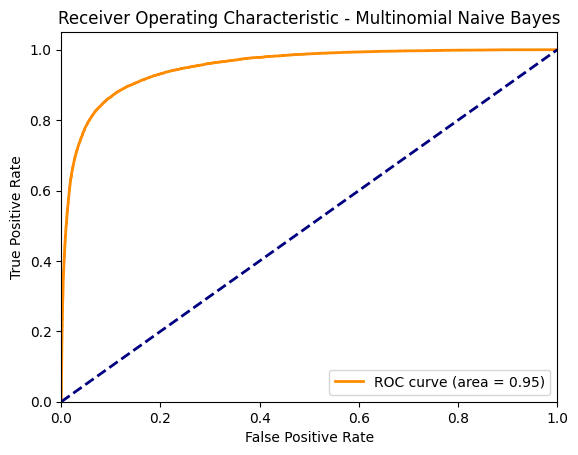

In [ ]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multinomial Naive Bayes')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

In [ ]:
# Define the Logistic Regression classifier and its hyperparameter distribution
log_reg_clf = LogisticRegression(max_iter=20000, class_weight='balanced', solver='liblinear')  # Adding class weights and using 'liblinear' solver
log_reg_param_dist = {
    'clf__C': uniform(0.1, 10)
}

In [ ]:
# Create a pipeline with TF-IDF, StandardScaler, TruncatedSVD, and the classifier
log_reg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),  # Use StandardScaler for scaling
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Reduce dimensionality to 100 components
    ('clf', log_reg_clf)
])

In [ ]:
# Perform RandomizedSearchCV for Logistic Regression
log_reg_random_search = RandomizedSearchCV(log_reg_pipeline, log_reg_param_dist, n_iter=20, cv=3, n_jobs=1, random_state=42)

In [ ]:
# Train the model
log_reg_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('scaler',
                                              StandardScaler(with_mean=False)),
                                             ('svd',
                                              TruncatedSVD(n_components=100,
                                                           random_state=42)),
                                             ('clf',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=20000,
                                                                 solver='liblinear'))]),
                   n_iter=20, n_jobs=1,
                   param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c8db2786380>},
                   random_state=42)

In [ ]:
# Predict on the test set
log_reg_y_pred = log_reg_random_search.predict(X_test)

In [ ]:
# Evaluate the model
print("Results for Logistic Regression:")
print("Best Parameters:", log_reg_random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, log_reg_y_pred))
print("Classification Report:\n", classification_report(y_test, log_reg_y_pred, target_names=['negative', 'positive']))
print("\n" + "="*80 + "\n")

Results for Logistic Regression:
Best Parameters: {'clf__C': 9.60714306409916}
Accuracy: 0.6326967728000864
Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.59      0.68     37037
    positive       0.47      0.71      0.56     18522

    accuracy                           0.63     55559
   macro avg       0.64      0.65      0.62     55559
weighted avg       0.69      0.63      0.64     55559





### ROC-AUC

ROC-AUC: 0.71


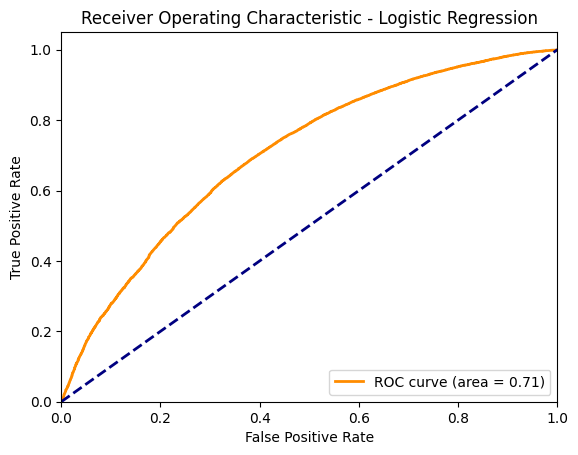

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming `log_reg_random_search` is your trained RandomizedSearchCV object

# Predict probabilities for the positive class
log_reg_y_proba = log_reg_random_search.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test, log_reg_y_proba)
fpr, tpr, _ = roc_curve(y_test, log_reg_y_proba)

# Print ROC-AUC
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

## Stochastic Gradient Descent (SGD)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier
from scipy.stats import uniform, reciprocal

In [ ]:
# Define the SGDClassifier and its hyperparameter distribution
sgd_clf = SGDClassifier(max_iter=20000, class_weight='balanced')

In [ ]:
sgd_param_dist = {
    'clf__alpha': reciprocal(1e-5, 1e-2),  # Regularization term
    'clf__penalty': ['l2', 'l1', 'elasticnet'],  # Type of regularization
    'clf__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Learning rate schedule
    'clf__eta0': uniform(1e-4, 1e-1),  # Initial learning rate
    'clf__tol': reciprocal(1e-5, 1e-1)  # Stopping criterion tolerance
}

In [ ]:
# Create a pipeline with TF-IDF, StandardScaler, TruncatedSVD, and the classifier
sgd_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),  # Use StandardScaler for scaling
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Reduce dimensionality to 100 components
    ('clf', sgd_clf)
])

In [ ]:
# Perform RandomizedSearchCV for SGDClassifier
sgd_random_search = RandomizedSearchCV(sgd_pipeline, sgd_param_dist, n_iter=50, cv=3, n_jobs=1, random_state=42)

In [ ]:
# Train the model
sgd_random_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('scaler',
                                              StandardScaler(with_mean=False)),
                                             ('svd',
                                              TruncatedSVD(n_components=100,
                                                           random_state=42)),
                                             ('clf',
                                              SGDClassifier(class_weight='balanced',
                                                            max_iter=20000))]),
                   n_iter=50, n_jobs=1,
                   param_distributions={'clf__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c8db1da5060>,
                                        'clf__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c8db1863c10>,
                                        'clf__learning_rate': ['constant',
                                                               'optimal',
                                                               'invscaling',
                                                               'adaptive'],
                                        'clf__penalty': ['l2', 'l1',
                                                         'elasticnet'],
                                        'clf__tol': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c8db1da4400>},
                   random_state=42)

In [ ]:
# Predict on the test set
sgd_y_pred = sgd_random_search.predict(X_test)

In [ ]:
# Evaluate the model
print("Results for Stochastic Gradient Descent (SGD) Classifier:")
print("Best Parameters:", sgd_random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, sgd_y_pred))
print("Classification Report:\n", classification_report(y_test, sgd_y_pred, target_names=['negative', 'positive']))
print("\n" + "="*80 + "\n")

Results for Stochastic Gradient Descent (SGD) Classifier:
Best Parameters: {'clf__alpha': 1.4270403521460843e-05, 'clf__eta0': 0.027964646423661144, 'clf__learning_rate': 'constant', 'clf__penalty': 'l2', 'clf__tol': 9.083381663660575e-05}
Accuracy: 0.6322468006983567
Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.56      0.67     37037
    positive       0.47      0.77      0.58     18522

    accuracy                           0.63     55559
   macro avg       0.65      0.67      0.63     55559
weighted avg       0.71      0.63      0.64     55559





### ROC-AUC

ROC-AUC: 0.70


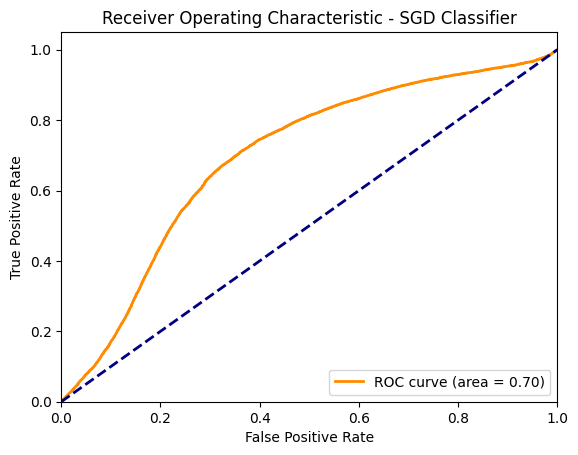

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming `sgd_random_search` is your trained RandomizedSearchCV object

# Get decision scores for the test set
sgd_y_scores = sgd_random_search.decision_function(X_test)

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test, sgd_y_scores)
fpr, tpr, _ = roc_curve(y_test, sgd_y_scores)

# Print ROC-AUC
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SGD Classifier')
plt.legend(loc="lower right")
plt.show()

### Random Forest

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

In [ ]:
# Define the Random Forest Classifier and its hyperparameter distribution
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

In [ ]:
rf_param_dist = {
    'clf__n_estimators': randint(10, 200),  # Number of trees in the forest
    'clf__max_depth': randint(1, 20),  # Maximum depth of the tree
    'clf__min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'clf__min_samples_leaf': randint(1, 20),  # Minimum number of samples required to be at a leaf node
    'clf__max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
}

In [ ]:
# Create a pipeline with TF-IDF, StandardScaler, TruncatedSVD, and the classifier
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('scaler', StandardScaler(with_mean=False)),  # Use StandardScaler for scaling
    ('svd', TruncatedSVD(n_components=100, random_state=42)),  # Reduce dimensionality to 100 components
    ('clf', rf_clf)
])

In [ ]:
# Perform RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(rf_pipeline, rf_param_dist, n_iter=50, cv=3, n_jobs=-1, random_state=42)

In [ ]:
# Train the model
rf_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('scaler',
                                              StandardScaler(with_mean=False)),
                                             ('svd',
                                              TruncatedSVD(n_components=100,
                                                           random_state=42)),
                                             ('clf',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__max_depth': <scipy.stats._distn_infrastructure.rv_disc...
                                        'clf__max_features': ['sqrt', 'log2',
                                                              None],
                                        'clf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c8dae5ce410>,
                                        'clf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c8dae5ce140>,
                                        'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c8dae5cd510>},
                   random_state=42)

In [ ]:
# Predict on the test set
rf_y_pred = rf_random_search.predict(X_test)# Predict on the test set

In [ ]:
# Evaluate the model
print("Results for Random Forest (RF) Classifier:")
print("Best Parameters:", rf_random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, rf_y_pred))
print("Classification Report:\n", classification_report(y_test, rf_y_pred, target_names=['negative', 'positive']))
print("\n" + "="*80 + "\n")

Results for Random Forest (RF) Classifier:
Best Parameters: {'clf__max_depth': 15, 'clf__max_features': None, 'clf__min_samples_leaf': 12, 'clf__min_samples_split': 9, 'clf__n_estimators': 184}
Accuracy: 0.8172933278136756
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.86      0.86     37037
    positive       0.72      0.73      0.73     18522

    accuracy                           0.82     55559
   macro avg       0.79      0.80      0.79     55559
weighted avg       0.82      0.82      0.82     55559





### AUC-ROC

ROC-AUC: 0.89


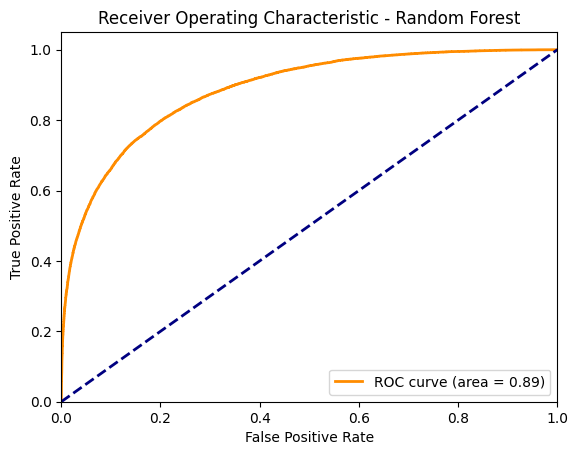

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming rf_random_search is your trained RandomizedSearchCV object

# Predict probabilities for the positive class
rf_y_proba = rf_random_search.predict_proba(X_test)[:, 1]

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test, rf_y_proba)
fpr, tpr, _ = roc_curve(y_test, rf_y_proba)

# Print ROC-AUC
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

## SVM

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import joblib
import numpy as np

In [ ]:
# Define the pipeline with a linear kernel SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

In [ ]:
# Define parameter grid for linear SVM
param_distributions = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear']  # Only use linear kernel
}

In [ ]:
# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, scoring='roc_auc', n_jobs=-1, cv=3, random_state=42, verbose=1)

In [ ]:
# Train the model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('svc', SVC())]),
                   n_jobs=-1,
                   param_distributions={'svc__C': [0.1, 1, 10],
                                        'svc__kernel': ['linear']},
                   random_state=42, scoring='roc_auc', verbose=1)

In [ ]:
# Save the best model
joblib.dump(random_search.best_estimator_, 'best_linear_svm_model.pkl')

['best_linear_svm_model.pkl']

In [ ]:
# Load the trained linear SVM model
best_model = joblib.load('best_linear_svm_model.pkl')

# Extract the vectorizer and LinearSVC from the pipeline
vectorizer = best_model.named_steps['tfidf']
svm = best_model.named_steps['svc']

In [ ]:
# Set probability=True
svm.set_params(probability=True)

SVC(C=1, kernel='linear', probability=True)

In [ ]:
# Create a new pipeline with the updated SVM model
pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('svc', svm)
])

In [ ]:
# Refit the model on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('svc', SVC(C=1, kernel='linear', probability=True))])

In [ ]:
# Save the updated model
joblib.dump(pipeline, 'best_linear_svm_model_with_proba.pkl')

['best_linear_svm_model_with_proba.pkl']

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
# Load the updated model
best_model_with_proba = joblib.load('best_linear_svm_model_with_proba.pkl')

In [ ]:
# Make predictions on the test set
y_pred_proba = best_model_with_proba.predict_proba(X_test)[:, 1]

In [ ]:
# Compute the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9601539878507808


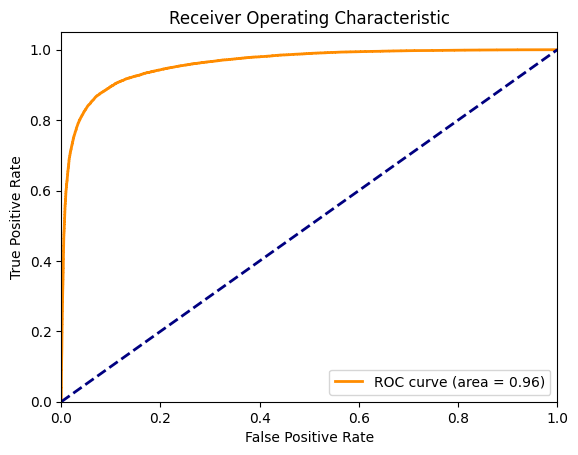

In [ ]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()